In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import yaml

data_yaml_content = {
    'train': '/content/drive/MyDrive/vegetation segmentation.v2i.yolov8/train',
    'test': '/content/drive/MyDrive/vegetation segmentation.v2i.yolov8/test',
    'val': '/content/drive/MyDrive/vegetation segmentation.v2i.yolov8/valid',
    'nc': 1, # number of classes
    'names': ['vegetation'] # class names
}

with open('data.yaml', 'w') as file:
    yaml.dump(data_yaml_content, file, default_flow_style=None)

print("data.yaml file created successfully.")

data.yaml file created successfully.


In [3]:
pip install albumentations

In [4]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.1 MB/s eta 0:00:00


In [5]:
# , pandas, Numpy, OpenCv, Rasgterio, scikitlearn, Folium, GeoPandas, Matplotlib, Seaborn, Streamlit, Dash

## Train the YOLO model

### Subtask:
Train the loaded YOLO model on the custom dataset using the specified paths and early stopping.

**Reasoning**:
Use the `model.train()` method with the provided training and validation data paths. While there isn't a direct 'early stop method' as a single parameter in `model.train()`, early stopping is a technique often used during training. The `ultralytics` library handles early stopping internally based on monitoring metrics like validation loss.

In [6]:
%pip install ultralytics

In [7]:
from ultralytics import YOLO

# Load a pre-trained YOLO model
model = YOLO('yolov8m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
# Install/upgrade ultralytics if needed
!pip install -U ultralytics -q

from ultralytics import YOLO

# Choose a larger model if you have GPU memory: "yolov8s.pt" or "yolov8m.pt"
model = YOLO("yolov8m.pt")

# Train with stronger augmentations, larger imgsz, and SGD optimizer (often better generalization)
results = model.train(
    data="/content/data.yaml",   # your data yaml
    epochs=200,                 # more epochs - early stopping will prevent overfitting
    batch=16,                   # adjust to GPU memory
    imgsz=1024,                  # larger image size; must be multiple of 32 (e.g. 768, 896, 1024)
    optimizer="SGD",            # try SGD with momentum
    lr0=0.01,                   # initial LR (try 0.01 with SGD)
    lrf=0.01,                   # final lr multiplier
    momentum=0.937,
    weight_decay=0.0005,
    patience=20,                # early stopping patience
    augment=True,               # enable built-in augmentations
    auto_augment="randaugment", # if available
    mosaic=1.0,
    mixup=0.2,
    copy_paste=0.15,
    cos_lr=True,                # cosine LR decay
    save=True,
    name="train_improve_map",
    conf=0.1,
    device=0                    # use GPU 0; use "cpu" if no GPU
)


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=0.1, copy_paste=0.15, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_improve_map, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0

In [12]:
# Evaluate model on validation set
metrics = model.val()
print(metrics)


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 71.1±16.9 MB/s, size: 174.2 KB)
val: Scanning /content/drive/MyDrive/vegetation segmentation.v2i.yolov8/valid/labels.cache... 59 images, 9 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 59/59 71.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.3it/s 11.7s
                   all         59        132      0.701      0.583      0.661      0.466
Speed: 18.1ms preprocess, 147.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /content/runs/detect/train_improve_map4
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793b7c43e2d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-

In [15]:
# Extract precision and recall
precision = metrics.results_dict['metrics/precision(B)']
recall = metrics.results_dict['metrics/recall(B)']

# Compute F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Extract mAP50 (accuracy proxy for object detection/segmentation)
map50 = metrics.results_dict['metrics/mAP50(B)']

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"mAP50 (Accuracy proxy): {map50:.4f}")


Precision: 0.7006
Recall: 0.5833
F1 Score: 0.6366
mAP50 (Accuracy proxy): 0.6605



image 1/1 /content/drive/MyDrive/vegetation segmentation.v2i.yolov8/test/images/0-1-14_png.rf.571ebae03cd52ceac7ac1beee7c4e52e.jpg: 1024x1024 2 vegetations, 184.2ms
Speed: 5.9ms preprocess, 184.2ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to /content/runs/detect/train_improve_map9


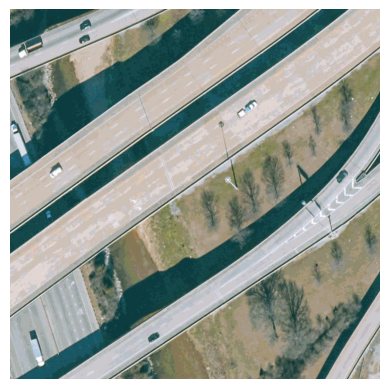

In [18]:
import cv2
import matplotlib.pyplot as plt

# Run inference on a single image
img_path = "/content/drive/MyDrive/vegetation segmentation.v2i.yolov8/test/images/0-1-14_png.rf.571ebae03cd52ceac7ac1beee7c4e52e.jpg"
results = model.predict(source=img_path, save=True, conf=0.25)

# Display inference
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [19]:
# Run inference on all test images
results = model.predict(
    source="/content/drive/MyDrive/vegetation segmentation.v2i.yolov8/valid/images",
    save=True,
    conf=0.25
)



image 1/59 /content/drive/MyDrive/vegetation segmentation.v2i.yolov8/valid/images/0-0-20_png.rf.fc47a980f69ef8a4fca62f2ba0020b5c.jpg: 1024x1024 2 vegetations, 167.6ms
image 2/59 /content/drive/MyDrive/vegetation segmentation.v2i.yolov8/valid/images/0-10-9_png.rf.9d52e3f2e793ce21ce737e4c69f66a70.jpg: 1024x1024 1 vegetation, 129.1ms
image 3/59 /content/drive/MyDrive/vegetation segmentation.v2i.yolov8/valid/images/0-11-46_png.rf.1252e9afbcafddbf1ffd8d6ff6c7dff5.jpg: 1024x1024 1 vegetation, 121.1ms
image 4/59 /content/drive/MyDrive/vegetation segmentation.v2i.yolov8/valid/images/0-12-2_png.rf.88338502f55abbbdb215779d568397d4.jpg: 1024x1024 1 vegetation, 122.7ms
image 5/59 /content/drive/MyDrive/vegetation segmentation.v2i.yolov8/valid/images/0-14-44_png.rf.52f4eefd419b51e697ea101f422abf17.jpg: 1024x1024 1 vegetation, 122.6ms
image 6/59 /content/drive/MyDrive/vegetation segmentation.v2i.yolov8/valid/images/0-14-7_png.rf.b3ec9ff5ed49936c9a6ec843685be78d.jpg: 1024x1024 1 vegetation, 124.8ms
